In [1]:
# example : https://hackmd.io/@lido2370/SJMPbNnKN?type=view
#           https://morvanzhou.github.io/tutorials/machine-learning/torch/4-01-CNN/
#           https://morvanzhou.github.io/tutorials/machine-learning/torch/3-02-classification/
#           https://discuss.pytorch.org/t/runtimeerror-multi-target-not-supported-newbie/10216/4
#           https://brohrer.mcknote.com/zh-Hant/how_machine_learning_works/how_convolutional_neural_networks_work.html

from torch.autograd import Variable
import torch , torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as activite
import torch.utils.data as Data

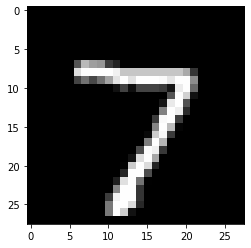

In [22]:
# Step1. Download MNIST dataset and prepare dataset to train

## choose seed of random 
np.random.seed(0)
torch.manual_seed(0)    # reproducible

## setup parameter       
BATCH_SIZE   = 50
image_number = 2000
  
## Download data of MNIST 
DOWNLOAD_MNIST = False   # If you don't want to download , please setup "False"
data_path = './mnist/'

train_data = torchvision.datasets.MNIST(
    root = data_path,    
    train = True,  # this is training data
    transform = torchvision.transforms.ToTensor(),                                                     
    download = DOWNLOAD_MNIST,          
)

test_data = torchvision.datasets.MNIST( root = data_path , train = False )

## Train 50 samples by one epoch , 1 channel , 28x28 (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)


## we just test 2000 image
test_image = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:image_number]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)

test_label = test_data.test_labels[:image_number]


## show number
test_image_numpy = test_image.data.numpy()
first_image      = np.reshape( test_image_numpy[0] , (28,28) )
plt.imshow(first_image, cmap=plt.get_cmap('gray'))

In [5]:
# Step2. Build CNN model
# information : https://ptorch.com/news/57.html
#               https://ptorch.com/news/8.html
#               https://medium.com/@chih.sheng.huang821/%E5%8D%B7%E7%A9%8D%E7%A5%9E%E7%B6%93%E7%B6%B2%E8%B7%AF-convolutional-neural-network-cnn-%E5%8D%B7%E7%A9%8D%E8%A8%88%E7%AE%97%E4%B8%AD%E7%9A%84%E6%AD%A5%E4%BC%90-stride-%E5%92%8C%E5%A1%AB%E5%85%85-padding-94449e638e82
#               https://medium.com/@chih.sheng.huang821/%E5%8D%B7%E7%A9%8D%E7%A5%9E%E7%B6%93%E7%B6%B2%E8%B7%AF-convolutional-neural-network-cnn-%E5%8D%B7%E7%A9%8D%E9%81%8B%E7%AE%97-%E6%B1%A0%E5%8C%96%E9%81%8B%E7%AE%97-856330c2b703
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = torch.nn.Sequential(  # input shape( 1 ,28 ,28 )
          torch.nn.Conv2d(
            in_channels  = 1 , # input height
            out_channels = 16, # number_filters
            kernel_size  = 5 , # filter size 
            stride       = 1 , # filter step  
            padding      = 2 , # if want to keep the size of image , padding = ( kernel_size - 1) / 2  when stride = 1
              
                        ), # ouput shape (16,28,28) 
          torch.nn.ReLU(), # activation
          torch.nn.MaxPool2d(kernel_size = 2) , # ouput shape (16,14,14)  
        )  # self.conv1
        self.conv2 = torch.nn.Sequential( # input shape( 16,14,14 )
          torch.nn.Conv2d(
            in_channels  = 16 , # input height
            out_channels = 32 , # number_filters
            kernel_size  = 5  , # filter size 
            stride       = 1  , # filter step  
            padding      = 2  , # if want to keep the size of image , padding = ( kernel_size - 1) / 2  when stride = 1
                         ),
          torch.nn.ReLU(), # activation
          torch.nn.MaxPool2d(kernel_size = 2) , # ouput shape (32,7,7) 
        )  # sel.conv2
        self.out = torch.nn.Linear( 32*7*7 , 10 )
        
    def forward(self , input_tensor):
        first_layer_out  = self.conv1(input_tensor)
        second_layer_out = self.conv2(first_layer_out)
        second_layer_out = second_layer_out.view(second_layer_out.size(0) , -1  )  # Flatten and send value to output layer
        output = self.out(second_layer_out)
        return output , second_layer_out
    
cnn = CNN()            
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [9]:
# Step3. Train CNN model

## setup parameter       
Learning_Rate = 0.001
EPOCH = 1

## choose optimizer and loss_function
optimizer = torch.optim.Adam(cnn.parameters(), lr=Learning_Rate)   # optimize all cnn parameters
loss_function = torch.nn.CrossEntropyLoss()                        # the target label is not one-hotted


# training and testing
# information: https://www.itread01.com/content/1541821590.html
for epoch in range(EPOCH):
    for step, (batch_input, batch_label) in enumerate(train_loader):
        output = cnn(batch_input)[0]    # output is the probability about number 0 ~ 9 
        loss = loss_function(output , batch_label)
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        
        if (step + 1) % 50 == 0 :
            test_output, last_layer_output = cnn(test_image)
            prediction_label = torch.max(test_output , 1)[1].data.numpy()
            accuracy = float((prediction_label == test_label.data.numpy()).astype(int).sum()) / float(test_label.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)


Epoch:  0 | train loss: 0.2351 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1910 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1483 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1048 | test accuracy: 0.95
Epoch:  0 | train loss: 0.2476 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0138 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0256 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0447 | test accuracy: 0.96
Epoch:  0 | train loss: 0.2071 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0670 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1421 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1536 | test accuracy: 0.97
Epoch:  0 | train loss: 0.5390 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0887 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0612 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0344 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0619 | test accuracy: 0.97
Epoch:  0 | train loss: 0.3124 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0639 | test accuracy

predict nuber : 7
real number   : 7


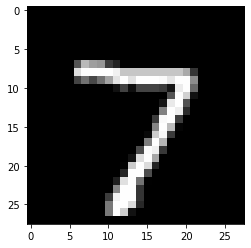

predict nuber : 2
real number   : 2


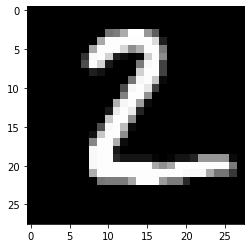

predict nuber : 1
real number   : 1


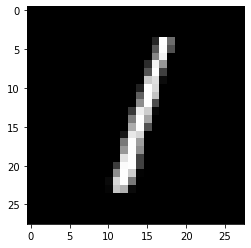

predict nuber : 0
real number   : 0


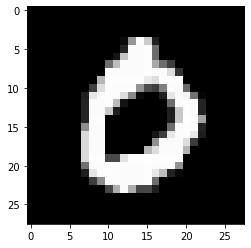

predict nuber : 4
real number   : 4


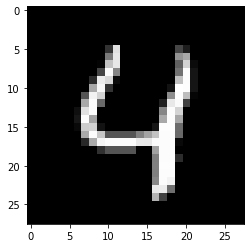

predict nuber : 1
real number   : 1


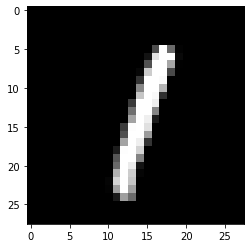

predict nuber : 4
real number   : 4


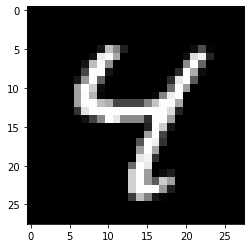

predict nuber : 9
real number   : 9


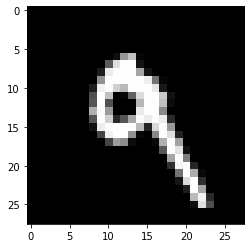

predict nuber : 5
real number   : 5


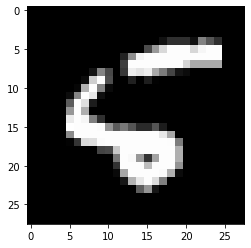

predict nuber : 9
real number   : 9


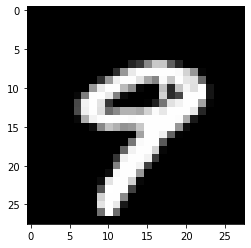

In [31]:
# Step4. view the prediction

want_to_view = 10

view_output = cnn(test_image[ : want_to_view] )[0]
view_prediction = torch.max(view_output , 1)[1].data.numpy()

for index in range( want_to_view ):
    plt.cla()
    print ( "predict nuber : {}".format( view_prediction[ index ] ) )
    print ( "real number   : {}".format( test_label[ : want_to_view ].numpy()[ index ]  ))
    number_image = np.reshape( test_image_numpy[ index ] , (28,28) )
    plt.imshow(number_image, cmap=plt.get_cmap('gray'))
    plt.show()
